In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Tomato Plant disease/Datasets/valid.zip"

Archive:  /content/drive/MyDrive/Tomato Plant disease/Datasets/valid.zip
   creating: valid/Tomato___Bacterial_spot/
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0000.jpg  
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0001.jpg  
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0002.jpg  
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0003.jpg  
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0004.jpg  
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0005.jpg  
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0006.jpg  
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0007.jpg  
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0008.jpg  
  inflating: valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0009.jpg  
  inflating: valid/Tomato___Bacterial_spot/

In [ ]:
!unzip "/content/drive/MyDrive/Tomato Plant disease/Datasets/our dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0043.jpg  
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0044.jpg  
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0045.jpg  
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0046.jpg  
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0047.jpg  
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0048.jpg  
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0049.jpg  
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0050.jpg  
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0051.jpg  
  inflating: our dataset/train/Tomato___Target_Spot/Tomato___Target_Spot_train_0052.jpg  
  inflating: our dataset/train/Tomato___Target_Sp

In [ ]:
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torch.onnx
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report

from datetime import datetime

import os
import time
import json
import pickle
from tqdm import tqdm

In [ ]:
data_dir = "/content/our dataset"

In [ ]:
print(torch.__version__)

2.0.1+cu118


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
TRAINING_DATA_PATH = os.path.join(data_dir,"train")   # Replace this string with the PATH to train directory in the dataset.
VALIDATION_DATA_PATH = "/content/valid" # Replace this string with the PATH to valid directory in the dataset.
NUM_CLASSES = len(os.listdir(TRAINING_DATA_PATH))
NUM_CLASSES

10

In [ ]:
# Creating directories to store models, confusion matrices and the performance metrics

if not os.path.isdir("results"):
    os.mkdir("results")
results_dir = "results"


if not os.path.isdir("results/confusion_matrices"):
    os.mkdir("results/confusion_matrices")
cfm_dir = "results/confusion_matrices"

if not os.path.isdir("results/models"):
    os.mkdir("results/models")
model_dir = "results/models"

if not os.path.isdir("results/valid_metrics"):
    os.mkdir("results/valid_metrics")
json_dir = "results/valid_metrics"


In [ ]:
class TrainDataset():
    def __init__(self):
        self.root = TRAINING_DATA_PATH
        # self.img_count = 2520
        self.distribution_file_name = "results/Train_Data_Distribution.csv"
        self.dataset = self.load_data()


    def load_data(self):
        data_list=[]
        num_list=[]
        main_dir = os.listdir(self.root)
        for i,dir in enumerate(tqdm(main_dir)):
          num_list.append([dir,len(os.listdir(os.path.join(self.root,dir)))])
          images_list = os.listdir(os.path.join(self.root,dir))
          local_cnt = 0
          for img in images_list:
              data_list.append([dir,os.path.join(self.root,dir,img)])
              local_cnt+=1

        num_df = pd.DataFrame(num_list, columns=['Class', 'Number of Images'])
        # Display the DataFrame
        num_df.to_csv(self.distribution_file_name,index=False)

        df = pd.DataFrame(data_list, columns =['label', 'path'])

        return df

    # Returns the number of samples in the dataset.
    def __len__(self):
        return len(self.dataset)

    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.dataset.iloc[idx, 1])
        labels= self.dataset.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        resize = transforms.Compose(
             [ transforms.Resize((224,224)), transforms.ToTensor()])
        image = resize(image)   # Resize the images.
        return (
            image,
            int(labels_to_num[labels]),
        )

# Inheriting from above Dataset class
class ValDataset(TrainDataset):
    def __init__(self):
        self.root = VALIDATION_DATA_PATH
        # self.img_count = 480
        self.distribution_file_name = "results/Valid_Data_Distribution.csv"
        self.dataset = self.load_data()


In [ ]:
trainDataset = TrainDataset()

100%|██████████| 10/10 [00:00<00:00, 149.26it/s]


In [ ]:
trainDataset.dataset

,label,path
0,Tomato___Late_blight,/content/our dataset/train/Tomato___Late_bligh...
1,Tomato___Late_blight,/content/our dataset/train/Tomato___Late_bligh...
2,Tomato___Late_blight,/content/our dataset/train/Tomato___Late_bligh...
3,Tomato___Late_blight,/content/our dataset/train/Tomato___Late_bligh...
4,Tomato___Late_blight,/content/our dataset/train/Tomato___Late_bligh...
...,...,...
25205,Tomato___Target_Spot,/content/our dataset/train/Tomato___Target_Spo...
25206,Tomato___Target_Spot,/content/our dataset/train/Tomato___Target_Spo...
25207,Tomato___Target_Spot,/content/our dataset/train/Tomato___Target_Spo...
25208,Tomato___Target_Spot,/content/our dataset/train/Tomato___Target_Spo...


In [ ]:
valDataset = ValDataset()

100%|██████████| 10/10 [00:00<00:00, 582.28it/s]


In [ ]:
# Creating a dictionary
num_to_labels = {}
labels_to_num = {}
labels_name=[]
main_dir = os.listdir(TRAINING_DATA_PATH)
for i,dir in enumerate(main_dir):
    num_to_labels[i]= dir
    labels_to_num[dir] = i
    labels_name.append(dir)


with open("num_to_labels.json", "w") as outfile:
    json.dump(num_to_labels, outfile)

with open("labels_to_num.json", "w") as outfile:
    json.dump(labels_to_num, outfile)

In [ ]:
# Dataloader in pytorch to load train and validation dataset
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=64, shuffle=True)
print("Loaded Training data")
valDataloader = torch.utils.data.DataLoader(valDataset, batch_size=32, shuffle=True)
print("Loaded Validation data")

Loaded Training data
Loaded Validation data


In [ ]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

In [ ]:
def get_class_val_count(row, best_epoch):
    with open(json_dir+"/ep_"+str(best_epoch)+".json") as f:
        data = json.load(f)

    return data[row["Class"]]["support"]


def get_class_f1_score(row, best_epoch):
    with open(json_dir+"/ep_"+str(best_epoch)+".json") as f:
        data = json.load(f)

    return data[row["Class"]]["f1-score"]

In [ ]:
@torch.no_grad()
def valid(epoch,valdataloader,optimizer):#--
    model.eval()  # Sets the module in evaluation mode
    confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)
    tot_loss = 0
    y_true_total=[]
    y_pred_final=[]
    with torch.no_grad():
        for batch, (x, y) in enumerate(valdataloader):
                x,y = x.to(device),y.to(device)# Sets the tensors to device GPU if available
                # Sets the gradients of all optimized tensors to zero
                optimizer.zero_grad()
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred, y)
                print("Test batch: {}, epoch: {}".format(batch+1,epoch+1), end='\r')

                tot_loss += loss.item()
                y_true_total.extend(np.array(y.cpu()))#we need to convert gpu into cpu for numpy to perform there operation
                y_pred_final.extend(np.array(y_pred.argmax(dim=1).cpu()))
                for y_pred_img, y_img in zip(y_pred.argmax(dim=1), y):
                    confusion_matrix[y_img.item()][y_pred_img.item()] += 1


    valid_matrices= classification_report(y_true_total, y_pred_final, target_names=labels_name,output_dict=True)
    loss = (tot_loss/len(valdataloader.dataset))*100
    return loss, valid_matrices, confusion_matrix

In [ ]:
model = torchvision.models.get_model('mobilenet_v2', weights='MobileNet_V2_Weights.IMAGENET1K_V1')
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=NUM_CLASSES)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 61.7MB/s]


In [ ]:
def train(model, num_of_epochs = 30,early_stop_warnings=0):
    try:

        # Defining the Optimizer
        # optimizer = optim.Adam(model.parameters(), lr=0.001)
        optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

        epochs = []
        losses = []
        val_loss_prev_min = 100.0   #--
        early_stop_flag=0
        best_epoch=0

        matrices = pd.DataFrame(columns = ['epoch','train_accuracy','val_accuracy','val_loss','Macro Avg f1','Weighted Avg f1'])

        for epoch in range(num_of_epochs):
            val_loss = 0
            # Sets the Module in training mode
            model.train()
            y_true_total=[]
            y_pred_final=[]
            for batch, (x, y) in enumerate(tqdm(trainDataloader)):
                x, y = x.to(device), y.to(device)
                # Sets the gradients of all optimized tensors to zero
                optimizer.zero_grad()
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred, y)
                y_true_total.extend(np.array(y.cpu()))
                y_pred_final.extend(np.array(y_pred.argmax(dim=1).cpu()))#y_pred.argmax(dim=1) calculates the class label with the highest predicted probability for each example in the batch. This returns a tensor of predicted class labels.
                loss.backward()
                optimizer.step()



            train_matrices= classification_report(y_true_total, y_pred_final, target_names=labels_name,output_dict=True)

            val_loss, valid_matrices, confusion_matrix = valid(epoch,valDataloader, optimizer)


            # Early Stopping
            if((early_stop_warnings > 0 and val_loss_prev_min > val_loss) or early_stop_warnings == 0):
                torch.save(model.state_dict(), model_dir+"/model_ep_"+str(epoch+1)+".pth")

                out_file = open(json_dir+"/ep_"+str(epoch+1)+".json", "w")
                json.dump(valid_matrices, out_file, indent = 2)
                out_file.close()

                val_loss_prev_min = val_loss
                early_stop_flag=0
                best_epoch = epoch+1
            else:
                early_stop_flag+=1
                if(early_stop_flag > early_stop_warnings):
                    print("\n!Early stopping triggered!\n")
                    break


            epochs.append(epoch)
            losses.append(val_loss)
            matrices = matrices.append({'epoch':epoch+1,'train_accuracy':train_matrices["accuracy"],
                                      'val_accuracy' : valid_matrices["accuracy"], 'val_loss' : val_loss,
                                      'Macro Avg f1' : valid_matrices["macro avg"]["f1-score"],
                                      'Weighted Avg f1':valid_matrices["weighted avg"]["f1-score"]}, ignore_index = True)
            print("Epoch {}, Train Accuracy : {}, Train Weighted Avg f1 Score: {}, Val Accuracy : {}, Val loss: {}, Val Macro Avg f1 {}, Val Weighted Avg f1 {}".format(epoch+1,
                train_matrices["accuracy"],train_matrices["weighted avg"]["f1-score"],valid_matrices["accuracy"],(val_loss),valid_matrices["macro avg"]["f1-score"],
                valid_matrices["weighted avg"]["f1-score"]))



            df_cm = pd.DataFrame(confusion_matrix, index = [str(num_to_labels[i]) for i in range(0,NUM_CLASSES)],
                                columns = [str(num_to_labels[i]) for i in range(0,NUM_CLASSES)])
            fig=plt.figure()
            plt.figure(figsize = (20,20))
            sn.heatmap(df_cm, annot=True, fmt = 'g')
            #plt.xlabel('Predicted Values-->', fontsize=10)
            #plt.ylabel('True Values------->', fontsize=10)
            plt.close(fig)
            plt.savefig(cfm_dir+"/cfsn_mtrx_epoch_"+str(epoch+1)+".jpg")
            plt.close()


        data_distribution_df = pd.read_csv("results/Train_Data_Distribution.csv")
        data_distribution_df['Number of Validation Images'] = data_distribution_df.apply(get_class_val_count, args=(best_epoch,), axis=1)
        data_distribution_df['f1-Score'] = data_distribution_df.apply(get_class_f1_score, args=(best_epoch,), axis=1)
        data_distribution_df.to_csv("results/Best Model Data Distribution Analysis.csv",index=False)


        # Saving validation matrices for further analysis
        matrices.to_csv('results/valid_matrices.csv',index = False)
    except Exception as e:
        print(f"An exception occurred: {str(e)}")
        matrices.to_csv('results/valid_matrices.csv',index = False)

In [ ]:
import warnings

# ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
train(model, num_of_epochs = 30, early_stop_warnings=2)

100%|██████████| 394/394 [02:06<00:00,  3.12it/s]


Epoch 1, Train Accuracy : 0.40959936533121777, Train Weighted Avg f1 Score: 0.40301270739509026, Val Accuracy : 0.6960416666666667, Val loss: 4.115053477386634, Val Macro Avg f1 0.6879239577119403, Val Weighted Avg f1 0.6879239577119401


100%|██████████| 394/394 [01:53<00:00,  3.47it/s]


Epoch 2, Train Accuracy : 0.7421261404204681, Train Weighted Avg f1 Score: 0.7378439276763298, Val Accuracy : 0.8058333333333333, Val loss: 2.2281159348785877, Val Macro Avg f1 0.8034579982497675, Val Weighted Avg f1 0.8034579982497674


100%|██████████| 394/394 [01:51<00:00,  3.52it/s]


Epoch 3, Train Accuracy : 0.8259817532725109, Train Weighted Avg f1 Score: 0.8247560605591496, Val Accuracy : 0.8502083333333333, Val loss: 1.5523011094580093, Val Macro Avg f1 0.8494536711331803, Val Weighted Avg f1 0.8494536711331804


100%|██████████| 394/394 [01:53<00:00,  3.46it/s]


Epoch 4, Train Accuracy : 0.8638238794129314, Train Weighted Avg f1 Score: 0.8630338091855914, Val Accuracy : 0.878125, Val loss: 1.2108843972285588, Val Macro Avg f1 0.8776178013327451, Val Weighted Avg f1 0.8776178013327451


100%|██████████| 394/394 [01:51<00:00,  3.53it/s]


Epoch 5, Train Accuracy : 0.8875446251487505, Train Weighted Avg f1 Score: 0.8870272698100722, Val Accuracy : 0.8983333333333333, Val loss: 1.0058306210363905, Val Macro Avg f1 0.8977971409079737, Val Weighted Avg f1 0.8977971409079737


100%|██████████| 394/394 [01:53<00:00,  3.48it/s]


Epoch 6, Train Accuracy : 0.9034113447044824, Train Weighted Avg f1 Score: 0.9031091022798677, Val Accuracy : 0.9133333333333333, Val loss: 0.8750203779588144, Val Macro Avg f1 0.9129238510390149, Val Weighted Avg f1 0.912923851039015


100%|██████████| 394/394 [01:51<00:00,  3.53it/s]


Epoch 7, Train Accuracy : 0.9169377231257437, Train Weighted Avg f1 Score: 0.9166425713264614, Val Accuracy : 0.92125, Val loss: 0.7710002636692176, Val Macro Avg f1 0.9209312246995038, Val Weighted Avg f1 0.9209312246995038


100%|██████████| 394/394 [01:53<00:00,  3.49it/s]


Epoch 8, Train Accuracy : 0.9274097580325268, Train Weighted Avg f1 Score: 0.9271444705368019, Val Accuracy : 0.9285416666666667, Val loss: 0.692796671918283, Val Macro Avg f1 0.9284107546156705, Val Weighted Avg f1 0.9284107546156704


100%|██████████| 394/394 [01:52<00:00,  3.50it/s]


Epoch 9, Train Accuracy : 0.9363347877826259, Train Weighted Avg f1 Score: 0.9362302931715013, Val Accuracy : 0.9339583333333333, Val loss: 0.6303373125071327, Val Macro Avg f1 0.9336033328266502, Val Weighted Avg f1 0.9336033328266501


100%|██████████| 394/394 [01:53<00:00,  3.48it/s]


Epoch 10, Train Accuracy : 0.9447044823482745, Train Weighted Avg f1 Score: 0.9445778018565417, Val Accuracy : 0.9408333333333333, Val loss: 0.5676730888274808, Val Macro Avg f1 0.9405284674360272, Val Weighted Avg f1 0.9405284674360272


100%|██████████| 394/394 [01:52<00:00,  3.50it/s]


Epoch 11, Train Accuracy : 0.9507735025783419, Train Weighted Avg f1 Score: 0.9506573692788781, Val Accuracy : 0.9464583333333333, Val loss: 0.5252958980466549, Val Macro Avg f1 0.9462296405660939, Val Weighted Avg f1 0.946229640566094


100%|██████████| 394/394 [01:54<00:00,  3.43it/s]


Epoch 12, Train Accuracy : 0.9557715192383974, Train Weighted Avg f1 Score: 0.9556659170195866, Val Accuracy : 0.94875, Val loss: 0.48888804158195853, Val Macro Avg f1 0.9485649814622675, Val Weighted Avg f1 0.9485649814622676


100%|██████████| 394/394 [01:52<00:00,  3.51it/s]


Epoch 13, Train Accuracy : 0.9595398651328838, Train Weighted Avg f1 Score: 0.9595032771272886, Val Accuracy : 0.9564583333333333, Val loss: 0.4565040113714834, Val Macro Avg f1 0.9562780120657097, Val Weighted Avg f1 0.9562780120657095


100%|██████████| 394/394 [01:53<00:00,  3.48it/s]


Epoch 14, Train Accuracy : 0.9652915509718366, Train Weighted Avg f1 Score: 0.9652395859244116, Val Accuracy : 0.9595833333333333, Val loss: 0.4221929279156029, Val Macro Avg f1 0.9593856283445377, Val Weighted Avg f1 0.9593856283445378


100%|██████████| 394/394 [01:54<00:00,  3.43it/s]


Epoch 15, Train Accuracy : 0.9681475604918683, Train Weighted Avg f1 Score: 0.9681091054519818, Val Accuracy : 0.9614583333333333, Val loss: 0.39874892910787213, Val Macro Avg f1 0.9613909047232175, Val Weighted Avg f1 0.9613909047232173


100%|██████████| 394/394 [01:52<00:00,  3.49it/s]


Epoch 16, Train Accuracy : 0.9727885759619199, Train Weighted Avg f1 Score: 0.9727709872567101, Val Accuracy : 0.9635416666666666, Val loss: 0.3827053622420256, Val Macro Avg f1 0.9634456619988618, Val Weighted Avg f1 0.963445661998862


100%|██████████| 394/394 [01:51<00:00,  3.53it/s]


Epoch 17, Train Accuracy : 0.9742959143197144, Train Weighted Avg f1 Score: 0.9742781391510229, Val Accuracy : 0.9658333333333333, Val loss: 0.36117092811036855, Val Macro Avg f1 0.9657632688408615, Val Weighted Avg f1 0.9657632688408616


100%|██████████| 394/394 [01:54<00:00,  3.45it/s]


Epoch 18, Train Accuracy : 0.9773899246330822, Train Weighted Avg f1 Score: 0.9773647785260999, Val Accuracy : 0.9675, Val loss: 0.3425313802241969, Val Macro Avg f1 0.9674098951741467, Val Weighted Avg f1 0.967409895174147


100%|██████████| 394/394 [01:51<00:00,  3.52it/s]


Epoch 19, Train Accuracy : 0.9795715985719953, Train Weighted Avg f1 Score: 0.979555204704121, Val Accuracy : 0.969375, Val loss: 0.3280178167624399, Val Macro Avg f1 0.9692872603254917, Val Weighted Avg f1 0.9692872603254917


100%|██████████| 394/394 [01:53<00:00,  3.48it/s]


Epoch 20, Train Accuracy : 0.9822292740975803, Train Weighted Avg f1 Score: 0.9822169124240157, Val Accuracy : 0.9695833333333334, Val loss: 0.31304121972061694, Val Macro Avg f1 0.969528402253309, Val Weighted Avg f1 0.9695284022533089


100%|██████████| 394/394 [01:52<00:00,  3.51it/s]


Epoch 21, Train Accuracy : 0.9833002776675922, Train Weighted Avg f1 Score: 0.9832923575637271, Val Accuracy : 0.9727083333333333, Val loss: 0.2988133911955326, Val Macro Avg f1 0.9726542718028928, Val Weighted Avg f1 0.9726542718028928


100%|██████████| 394/394 [01:51<00:00,  3.52it/s]


Epoch 22, Train Accuracy : 0.9845696152320508, Train Weighted Avg f1 Score: 0.9845612617546653, Val Accuracy : 0.9727083333333333, Val loss: 0.2826739956896442, Val Macro Avg f1 0.9726401160072736, Val Weighted Avg f1 0.9726401160072735


100%|██████████| 394/394 [01:52<00:00,  3.49it/s]


Epoch 23, Train Accuracy : 0.9864339547798493, Train Weighted Avg f1 Score: 0.9864241704281522, Val Accuracy : 0.9735416666666666, Val loss: 0.2812495694573348, Val Macro Avg f1 0.9734926121366125, Val Weighted Avg f1 0.9734926121366125


100%|██████████| 394/394 [01:51<00:00,  3.53it/s]


Epoch 24, Train Accuracy : 0.9875446251487505, Train Weighted Avg f1 Score: 0.9875398671824334, Val Accuracy : 0.9754166666666667, Val loss: 0.2701239214511588, Val Macro Avg f1 0.9753614827545256, Val Weighted Avg f1 0.9753614827545258


100%|██████████| 394/394 [01:53<00:00,  3.48it/s]


Epoch 25, Train Accuracy : 0.989170963903213, Train Weighted Avg f1 Score: 0.9891677213499767, Val Accuracy : 0.9758333333333333, Val loss: 0.2621144318157652, Val Macro Avg f1 0.9757918737592981, Val Weighted Avg f1 0.9757918737592983


100%|██████████| 394/394 [01:52<00:00,  3.49it/s]


Epoch 26, Train Accuracy : 0.9900039666798889, Train Weighted Avg f1 Score: 0.9900031537432766, Val Accuracy : 0.97625, Val loss: 0.26153841469204053, Val Macro Avg f1 0.976190072867905, Val Weighted Avg f1 0.9761900728679048


100%|██████████| 394/394 [01:53<00:00,  3.48it/s]


Epoch 27, Train Accuracy : 0.9907973026576755, Train Weighted Avg f1 Score: 0.9907948545794346, Val Accuracy : 0.975, Val loss: 0.2512126870957824, Val Macro Avg f1 0.9749751793811129, Val Weighted Avg f1 0.9749751793811129


100%|██████████| 394/394 [01:52<00:00,  3.51it/s]


Epoch 28, Train Accuracy : 0.99230464101547, Train Weighted Avg f1 Score: 0.9923044659960185, Val Accuracy : 0.9754166666666667, Val loss: 0.2468381780636264, Val Macro Avg f1 0.9753733386405999, Val Weighted Avg f1 0.9753733386405999


100%|██████████| 394/394 [01:54<00:00,  3.44it/s]


Epoch 29, Train Accuracy : 0.9928599761999206, Train Weighted Avg f1 Score: 0.9928590497956646, Val Accuracy : 0.97875, Val loss: 0.23099182018389303, Val Macro Avg f1 0.9787349241224014, Val Weighted Avg f1 0.9787349241224015


100%|██████████| 394/394 [01:53<00:00,  3.49it/s]


Epoch 30, Train Accuracy : 0.9925029750099167, Train Weighted Avg f1 Score: 0.992503173137147, Val Accuracy : 0.9777083333333333, Val loss: 0.23803079318410406, Val Macro Avg f1 0.9776474609677462, Val Weighted Avg f1 0.9776474609677461


In [ ]:
with open("labels_to_num.json", "w") as outfile:
    json.dump(labels_to_num, outfile)

In [ ]:
with open("num_to_labels.json", "w") as outfile:
    json.dump(num_to_labels, outfile)

In [ ]:
analyse_df = pd.read_csv("results/valid_matrices.csv")

In [ ]:
# analyse_df = analyse_df.assign(val_accuracy = lambda x: (x['val_accuracy']* 100))

In [ ]:
analyse_df

,epoch,train_accuracy,val_accuracy,val_loss,Macro Avg f1,Weighted Avg f1
0,1.0,0.409599,0.696042,4.115053,0.687924,0.687924
1,2.0,0.742126,0.805833,2.228116,0.803458,0.803458
2,3.0,0.825982,0.850208,1.552301,0.849454,0.849454
3,4.0,0.863824,0.878125,1.210884,0.877618,0.877618
4,5.0,0.887545,0.898333,1.005831,0.897797,0.897797
5,6.0,0.903411,0.913333,0.875020,0.912924,0.912924
6,7.0,0.916938,0.921250,0.771000,0.920931,0.920931
7,8.0,0.927410,0.928542,0.692797,0.928411,0.928411
8,9.0,0.936335,0.933958,0.630337,0.933603,0.933603
9,10.0,0.944704,0.940833,0.567673,0.940528,0.940528


<Figure size 640x480 with 0 Axes>

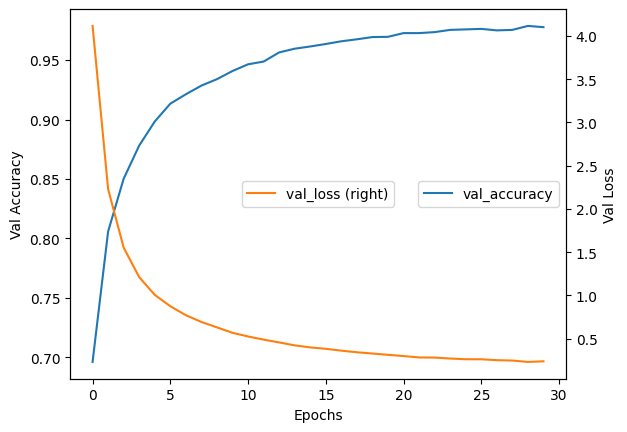

In [ ]:
plt.figure()
ax = analyse_df[['val_accuracy','val_loss']].plot(secondary_y=['val_loss'])
ax.set_ylabel('Val Accuracy')
ax.set_xlabel("Epochs")
ax.right_ax.set_ylabel('Val Loss')
ax.legend(loc='right')
ax.right_ax.legend(loc='center')

# Save the figure
plt.savefig('results/validation_plot.png')

In [ ]:
!zip -r "/content/drive/MyDrive/Tomato Plant disease/our_dataset_results.zip" results

  adding: results/ (stored 0%)
  adding: results/Train_Data_Distribution.csv (deflated 51%)
  adding: results/valid_metrics/ (stored 0%)
  adding: results/valid_metrics/ep_17.json (deflated 74%)
  adding: results/valid_metrics/ep_15.json (deflated 75%)
  adding: results/valid_metrics/ep_22.json (deflated 73%)
  adding: results/valid_metrics/ep_23.json (deflated 75%)
  adding: results/valid_metrics/ep_20.json (deflated 73%)
  adding: results/valid_metrics/ep_28.json (deflated 75%)
  adding: results/valid_metrics/ep_11.json (deflated 74%)
  adding: results/valid_metrics/ep_18.json (deflated 73%)
  adding: results/valid_metrics/ep_1.json (deflated 72%)
  adding: results/valid_metrics/ep_25.json (deflated 74%)
  adding: results/valid_metrics/ep_27.json (deflated 74%)
  adding: results/valid_metrics/ep_8.json (deflated 72%)
  adding: results/valid_metrics/ep_9.json (deflated 74%)
  adding: results/valid_metrics/ep_3.json (deflated 72%)
  adding: results/valid_metrics/ep_6.json (deflated 72%

In [ ]:
pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Testing

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = torchvision.models.get_model('mobilenet_v2', pretrained=True)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=NUM_CLASSES)
model.load_state_dict(torch.load('/content/model.pth'))
model = model.to(device)
model.eval()

In [ ]:
with open('/content/num_to_labels.json') as json_file:
    num_to_labels= json.load(json_file)

from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
# prediction function to test sample images
@torch.no_grad()
def predict(img_path):
    image = Image.open(img_path)
    resize = transforms.Compose(
                    [ transforms.Resize((256,256)), transforms.ToTensor()])
    image = resize(image)
    image = image.to(device)
    with torch.no_grad():
        y_result = torch.softmax(model(image.unsqueeze(0)),dim=1)
        result_idx = y_result.argmax(dim=1)
        print("Prediction : ",num_to_labels[str(int(result_idx))])
        image = Image.open(img_path)
        plt.imshow(image)

Prediction :  Tomato___Bacterial_spot


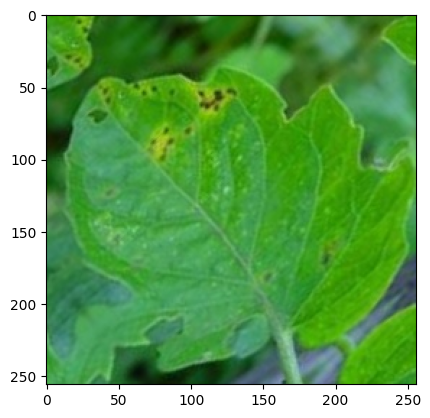

In [ ]:
predict("/content/valid/Tomato___Bacterial_spot/Tomato___Bacterial_spot_valid_0027.jpg")

Prediction :  Tomato___Late_blight


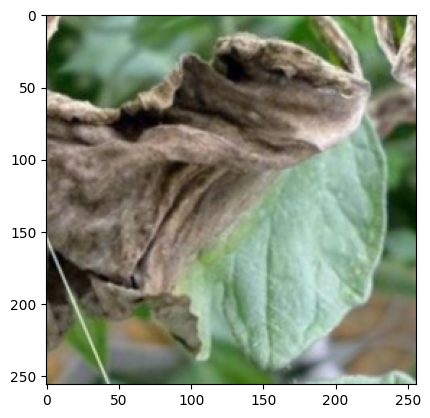

In [ ]:
predict("/content/valid/Tomato___Late_blight/Tomato___Late_blight_valid_0084.jpg")

Prediction :  Tomato___healthy


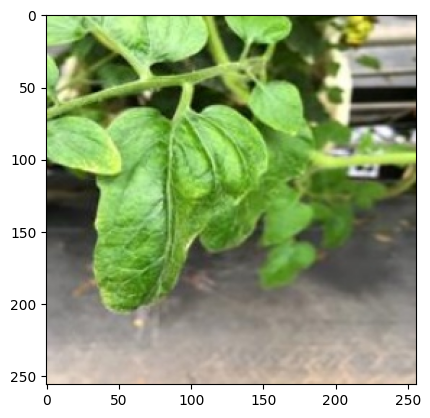

In [ ]:
predict("/content/valid/Tomato___healthy/Tomato___healthy_valid_0279.jpg")